In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First load in neural network

In [2]:
model_numpy=np.load("Neural/neural_model.npz")
w_array_0=np.matrix(model_numpy["w_array_0"])
b_array_0=np.matrix(model_numpy["b_array_0"])
w_array_1=np.matrix(model_numpy["w_array_1"])
b_array_1=np.matrix(model_numpy["b_array_1"])

In [3]:
# Input params:
xdata = np.load('../GibbsChem/Network Training Data/APOGEE Training Data.npz')
norm_params=xdata['norm_grid']

In [4]:
# Normalization Parameters
norm_means=xdata['means']
norm_widths=xdata['full_widths']

In [5]:
def neural_net(norm_params):
    if isinstance(norm_params[0],np.ndarray):
        n_stars=len(norm_params)
        layer1=np.matmul(norm_params,w_array_0.T)+np.matmul(np.matrix(np.ones(n_stars)).T,b_array_0)
        layer2=np.matmul(np.tanh(layer1),w_array_1.T)+np.matmul(np.matrix(np.ones(n_stars)).T,b_array_1)
    else: 
        layer1=np.dot(norm_params,w_array_0.T)+b_array_0
        layer2=np.dot(np.tanh(layer1),w_array_1.T)+b_array_1
    return(layer2)

### Read in APOGEE Data and Priors
- NB: Ages are in ln(years) here
- Priors are from Philcox+17

*This step is slightly unnecessary but could be useful if the prior means are not the same as the normalization means*

In [6]:
n_stars = 5
apogee=np.load('../GibbsChem/APOGEE_dataset.npz')
mu_ages = apogee['ln_age'][:n_stars]
sigma_ages = apogee['ln_age_err'][:n_stars]

In [7]:
# Proto-solar data
sol_data,sol_err=np.load('Chempy/input/stars/Proto-sun.npy')
sol_els = sol_data.dtype.names
sol_ages = np.log(sol_data[-1])
sol_sigma_ages = sol_err[-1]/sol_data[-1]

In [8]:
solar_abundances=[];solar_errors=[]
for name in apogee['names']:
    for i in range(len(sol_els)):
        if name==sol_els[i]:
            solar_abundances.append(sol_data[i])
            solar_errors.append(sol_err[i])

In [9]:
APOGEE_abundances=apogee['abun'][:n_stars]
APOGEE_errors=apogee['abun_err'][:n_stars]

In [10]:
# FOR TESTING
n_stars=1
mu_ages = [np.array(sol_ages)]
sigma_ages = [np.array(sol_sigma_ages)]
APOGEE_abundances=np.matrix(solar_abundances)
APOGEE_errors=np.matrix(solar_errors)

In [11]:
unnormalized_prior_means = norm_means[:5] 
unnormalized_prior_sigmas = norm_widths[:5]

In [12]:
# Read in priors:
Lambda_prior_mu = unnormalized_prior_means[:2]-norm_means[:2]
Lambda_prior_sigma = unnormalized_prior_sigmas[:2]/norm_widths[:2]
Theta_prior_mu = unnormalized_prior_means[2:5]-norm_means[2:5]
Theta_prior_sigma = unnormalized_prior_sigmas[2:5]/norm_widths[2:5]

# Define stacked local priors
Local_prior_mu = np.vstack([np.hstack([Theta_prior_mu,mu_ages[i]]) for i in range(n_stars)])
Local_prior_sigma = np.vstack([np.hstack([Theta_prior_sigma,sigma_ages[i]]) for i in range(n_stars)])

## Define Priors and Likelihoods

In [25]:
def neg_log_prior_global(Lambda):
    # Return prior for global parameters
    tmp = (Lambda-Lambda_prior_mu)/Lambda_prior_sigma
    return 0.5*np.sum(tmp**2.)
def neg_log_prior_local(Thetas,ages):
    # Return prior for local parameters
    # input is Thetas local variables, ages of stars
    # This returns a vector of priors for each star
    all_local=np.hstack([Thetas,ages])
    tmp = (all_local-Local_prior_mu)/Local_prior_sigma
    return 0.5*np.sum(np.square(tmp),axis=1)

In [26]:
def each_star_likelihood(Lambda,Thetas,ages):
    # Return negative log likelihood for each star
    Lambda_arr = np.vstack([Lambda for _ in range(len(ages))])
    prediction = neural_net(np.hstack([Lambda_arr,Thetas,ages]))
    true_data = APOGEE_abundances
    error = APOGEE_errors
    tmp = (prediction-true_data)/error
    return 0.5*np.sum(np.square(tmp),axis=1)
def all_star_likelihood(Lambda,Thetas,ages):
    # Return negative log likelihood for many stars
    predictions=neural_net(np.hstack([Lambda,Thetas,ages]))
    true_data = APOGEE_abundances
    error = APOGEE_errors
    temp_matrix = ((predictions-true_data)/error)
    return np.sum(np.matmul(temp_matrix,temp_matrix.T))

In [27]:
def Lambda_distribution(Lambda_new,Thetas,ages):
    # Probability distribution P(Lambda|Thetas,ages)
    # Returns negative log probability
    Lambda_array = np.matmul(np.matrix(np.ones(len(Thetas))).T,np.matrix(Lambda_new))
    return all_star_likelihood(Lambda_array,Thetas,ages)+neg_log_prior_global(Lambda_new)
def Local_distribution(Thetas_new,ages_new,Lambda):
    # Probability distribution P(Theta_j,age_j|Lambda) for star j
    # Returns negative log probability
    like=each_star_likelihood(Lambda,Thetas_new,ages_new)
    prior = neg_log_prior_local(Thetas_new,ages_new)
    return like+prior 

## Construct the Gibbs Sampler

In [29]:
## PARAMETERS
n_walk=16
a = 2.; # sampler proposal distribution
n_dim=len(Lambda_prior_mu); # spatial dimension
steps=5000
burn=500
local_repeats=3
global_repeats=3
seed = 1

# Initial Positions
initial_Lambda = Lambda_prior_mu+0.1*np.random.randn(len(Lambda_prior_mu))*Lambda_prior_sigma

np.random.seed(seed)

# Initialization: 
current_walkers = np.asarray([list(Lambda_prior_mu+0.1*np.random.randn(2)*Lambda_prior_sigma) for _ in range(n_walk)])
accept=0
accept_local=0
split_walk=int(n_walk/2) # for convenience
chain_walkers=np.zeros([n_dim,(burn+steps)*n_walk*global_repeats])
for i in range(n_walk):
    chain_walkers[:,i]=current_walkers[i]

# Initialize variables
local_dim=len(Theta_prior_mu)+1; # spatial dimension
local_walkers=np.zeros([n_walk,local_dim,n_stars])

for w in range(n_walk):
    for s in range(n_stars):
        for i in range(len(Theta_prior_mu)):
                local_walkers[w,i,s]=Theta_prior_mu[i]+0.1*np.random.randn()*Theta_prior_sigma[i]
        local_walkers[w,len(Theta_prior_mu),s]=mu_ages[s]+0.1*sigma_ages[s]*np.random.randn()

old_Thetas=local_walkers[:,1:,:]
old_Ages=local_walkers[:,0,:].reshape([n_walk,1,n_stars])

this_old_Thetas=old_Thetas[-1]
this_old_Ages=old_Ages[-1]

tmp_theta=np.zeros([old_Thetas.shape[1],n_stars,burn+steps])


mean_Ages=np.zeros_like(old_Ages[-1])
mean_Thetas=np.zeros_like(old_Thetas[-1])
        
# ALGORITHM:
for m in range(1,steps+burn):
    if m%500==0:
        print("Step %d of %d complete" %(m,steps+burn))
        
    ## GLOBAL UPDATE:
    # Choose some value for thetas and ages
    this_old_Thetas=old_Thetas[-1]
    this_old_Ages=old_Ages[-1]
    
    
    ## Update estimates of mean ages and thetas:
    if m>burn:
        mean_Ages+=this_old_Ages
        mean_Thetas+=this_old_Thetas
        for star_index in range(n_stars):
            tmp_theta[:,star_index,m]=this_old_Thetas[:,star_index]
     
    
    # First update probabilities:
    old_prob = np.asarray([Lambda_distribution(np.asarray(current_walkers[kk]),this_old_Thetas.T,this_old_Ages.T) for kk in range(2*split_walk)])

    for g in range(global_repeats):
        for i in range(2): # Split the ensemble into two sets
            # Update walkers in parallel:
            k_indices=range(split_walk*i,split_walk*(i+1))
            # Pick random walker indices from the other half of the ensemble
            if i==0:
                j_indices = list(np.random.randint(split_walk,2*split_walk,split_walk))
            if i==1:
                j_indices = list(np.random.randint(0,split_walk,split_walk))
            # Propose a new walker
            u=np.random.uniform(size=split_walk)
            Z = np.matrix(1./a*pow(u*(a-1.)+1.,2.))
            ZZ = np.matmul(Z.T,np.matrix(np.ones(n_dim)))
            proposed_walkers = current_walkers[j_indices]+np.multiply(ZZ,(current_walkers[k_indices]-current_walkers[j_indices]))
            # Define new probability

            ## TO DO: PARALLELIZE THIS:
            new_prob = np.asarray([Lambda_distribution(np.asarray(proposed_walkers[kk]),this_old_Thetas.T,this_old_Ages.T) for kk in range(split_walk)])

            # Now accept or reject walkers:
            rand = np.asmatrix(np.random.uniform(size=split_walk))
            tmp=np.multiply(np.power(Z,n_dim-1.),np.matrix(np.exp(old_prob[k_indices]-new_prob)))
            accept_indices = np.where(rand<tmp)[1]
            # Update probability and walkers:
            current_walkers[split_walk*i+np.asarray(accept_indices)]=proposed_walkers[accept_indices]
            old_prob[split_walk*i+np.asarray(accept_indices)]=new_prob[accept_indices]

            accept+=len(accept_indices)
            # Update chain:
            for k in k_indices:
                chain_walkers[:,g*global_repeats+m*n_walk*global_repeats+k]=current_walkers[k]

    ## LOCAL UPDATE
    current_Lambda=current_walkers[-1]#np.mean(current_walkers,axis=0)
    for r in range(local_repeats):
        for i in range(2):
            k_indices=range(split_walk*i,split_walk*(i+1))
            # Pick random walker indices from the other half of the ensemble
            if i==0:
                j_indices = list(np.random.randint(split_walk,2*split_walk,split_walk))
            if i==1:
                j_indices = list(np.random.randint(0,split_walk,split_walk))
            # Now iterate over walkers
            for id_k,k in enumerate(k_indices):
                # Define old probability
                old_local_probs = Local_distribution(np.asmatrix(old_Thetas[k]).T,np.asmatrix(old_Ages[k]).T,current_Lambda)
                # Propose a new walker
                u=np.random.uniform(size=n_stars)
                Z = np.matrix(1./a*pow(u*(a-1.)+1.,2.))
                ZZ = np.matmul(Z.T,np.matrix(np.ones(local_dim)))
                proposed_walkers = local_walkers[j_indices[id_k]]+np.multiply(ZZ.T,(local_walkers[k]-local_walkers[j_indices[id_k]]))
                # Compute new probability:
                new_local_probs = Local_distribution(proposed_walkers[1:].T,proposed_walkers[0].T,current_Lambda)
                # Now accept via a Metropolis step:
                random_variable = np.asmatrix(np.random.uniform(size=n_stars)).T
                accept_prob = np.exp(old_local_probs-new_local_probs)
                change_indices = np.where(random_variable<accept_prob)[0]
                if m>burn:
                    accept_local+=len(change_indices)

                # Now accept the steps for the relevant stars, keeping others constant:
                old_Thetas[k,:,change_indices]=np.asarray(proposed_walkers[1:,change_indices]).T
                old_Ages[k,:,change_indices]=np.asarray(proposed_walkers[0,change_indices]).T
                local_walkers[k,:,change_indices]=proposed_walkers[:,change_indices].T
        
# Compute averages
mean_Ages/=float(steps)
mean_Thetas/=float(steps)
# Compute acceptance fraction
accept_local=float(accept_local)/(n_stars*local_repeats*steps*n_walk)

print("Local Acceptance Fraction %.1f"%(accept_local))
      
print("Global Acceptance Fraction: %.2f" %(float(accept)/(global_repeats*steps*n_walk)))

Step 500 of 5500 complete
Step 1000 of 5500 complete
Step 1500 of 5500 complete
Step 2000 of 5500 complete
Step 2500 of 5500 complete
Step 3000 of 5500 complete
Step 3500 of 5500 complete
Step 4000 of 5500 complete
Step 4500 of 5500 complete
Step 5000 of 5500 complete
Local Acceptance Fraction 0.6
Global Acceptance Fraction: 0.65


In [30]:
# Now output the chain
thin=10
output_chain = chain_walkers[:,burn*n_walk::thin]

In [31]:
alpha_imf=output_chain[0,:]*norm_widths[0]+norm_means[0]
log10_N1a=output_chain[1,:]*norm_widths[1]+norm_means[1]

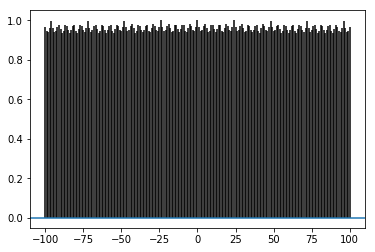

In [32]:
plt.acorr(alpha_imf,maxlags=100);

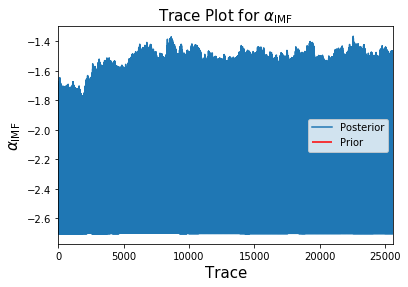

In [33]:
plt.plot(alpha_imf,label='Posterior');FS=15
plt.hlines(norm_means[0],0,len(alpha_imf),color='r',label='Prior')
plt.hlines(norm_means[0]-norm_widths[0],0,len(alpha_imf),color='r',linestyles='--')
plt.hlines(norm_means[0]+norm_widths[0],0,len(alpha_imf),color='r',linestyles='--')
plt.xlim([0,len(alpha_imf)]);plt.legend()
plt.ylabel(r'$\alpha_\mathrm{IMF}$',fontsize=FS)
plt.xlabel(r'Trace',fontsize=FS);
plt.title(r'Trace Plot for $\alpha_\mathrm{IMF}$',fontsize=FS);

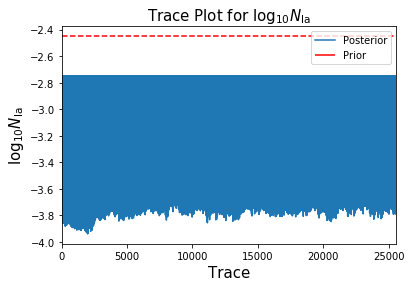

In [34]:
plt.plot(log10_N1a,label='Posterior');FS=15
plt.hlines(norm_means[1],0,len(log10_N1a),color='r',label='Prior')
plt.hlines(norm_means[1]-norm_widths[1],0,len(log10_N1a),color='r',linestyles='--')
plt.hlines(norm_means[1]+norm_widths[1],0,len(log10_N1a),color='r',linestyles='--')
plt.xlim([0,len(log10_N1a)]);plt.legend()
#plt.xlim([2100,2200])
plt.ylabel(r'$\log_{10}N_\mathrm{Ia}$',fontsize=FS)
plt.xlabel(r'Trace',fontsize=FS);
plt.title(r'Trace Plot for $\log_{10}N_\mathrm{Ia}$',fontsize=FS);

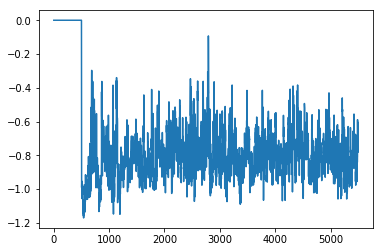

In [45]:
plt.plot(tmp_theta[0,0,:])

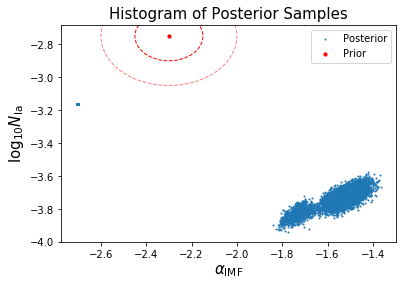

In [37]:
prior_ellipse=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],norm_widths[0],norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--')
prior_ellipse_2=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],2*norm_widths[0],2*norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--',alpha=0.5)

plt.scatter(alpha_imf,log10_N1a,s=1,label='Posterior')
plt.scatter(norm_means[0],norm_means[1],label='Prior',c='r',s=10)
plt.ylabel(r'$\log_{10}N_\mathrm{Ia}$',fontsize=FS);
plt.legend();
plt.xlabel(r'$\alpha_\mathrm{IMF}$',fontsize=FS)
plt.title(r'Histogram of Posterior Samples',fontsize=FS);
ax=plt.gca()
ax.add_patch(prior_ellipse)
ax=plt.gca()
ax.add_patch(prior_ellipse_2);